In [335]:
!pip install nltk
import nltk
nltk.download('punkt')


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


False

In [476]:
import os
import sys
import math
from collections import Counter
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F



In [477]:
def load_data(in_file):
    cn = []
    en = []
    num_examples = 0
    with open(in_file, 'r') as f:
        for line in f:
            line = line.strip().split("\t")

            en.append(["BOS"] + nltk.word_tokenize(line[0].lower()) + ["EOS"])
            cn.append(["BOS"] + [c for c in line[1]] + ["EOS"])
    return en, cn

train_file = "data/yue-eng2.txt"
dev_file = "data/yue-eng.txt"
train_en, train_cn = load_data(train_file)
dev_en, dev_cn = load_data(dev_file)

In [478]:
print(dev_en[:2])
print(dev_cn[:2])

[['BOS', 'begin', '.', 'EOS'], ['BOS', 'hello', '!', 'EOS']]
[['BOS', '開', '始', '啦', '。', 'EOS'], ['BOS', '哈', '佬', '。', 'EOS']]


In [479]:
UNK_IDX = 0
PAD_IDX = 1
def build_dict(sentences, max_words=50000):
    word_count = Counter()
    for sentence in sentences:
        for s in sentence:
            word_count[s] += 1
    ls = word_count.most_common(max_words)
    total_words = len(ls) + 2
    word_dict = {w[0]: index+2 for index, w in enumerate(ls)}
    word_dict["UNK"] = UNK_IDX
    word_dict["PAD"] = PAD_IDX
    return word_dict, total_words      #total_words所有单词数，最大50002

en_dict, en_total_words = build_dict(train_en)
cn_dict, cn_total_words = build_dict(train_cn)
inv_en_dict = {v: k for k, v in en_dict.items()}    #英文：索引到单词
inv_cn_dict = {v: k for k, v in cn_dict.items()}    #中文：索引到字

In [480]:
def encode(en_sentences, cn_sentences, en_dict, cn_dict, sort_by_len=True):

    length = len(en_sentences)
    out_en_sentences = [[en_dict.get(w, 0) for w in sent] for sent in en_sentences]
    out_cn_sentences = [[cn_dict.get(w, 0) for w in sent] for sent in cn_sentences]

    # sort sentences by word lengths
    def len_argsort(seq):
        return sorted(range(len(seq)), key=lambda x: len(seq[x]))

    # 把中文和英文按照同样的顺序排序
    if sort_by_len:
        sorted_index = len_argsort(out_en_sentences)
        out_en_sentences = [out_en_sentences[i] for i in sorted_index]
        out_cn_sentences = [out_cn_sentences[i] for i in sorted_index]

    return out_en_sentences, out_cn_sentences

train_en, train_cn = encode(train_en, train_cn, en_dict, cn_dict)
dev_en, dev_cn = encode(dev_en, dev_cn, en_dict, cn_dict)

In [481]:
print(train_cn[2])
print([inv_cn_dict[i] for i in train_cn[2]])
print([inv_en_dict[i] for i in train_en[2]])

[2, 81, 1749, 3]
['BOS', '手', '鏈', 'EOS']
['BOS', 'bracelet', 'EOS']


In [482]:
def get_minibatches(n, minibatch_size, shuffle=True):  #n是传进来的句子数
    idx_list = np.arange(0, n, minibatch_size)   #[0, 1, ..., n-1]按minibatch_size大小分割
    if shuffle:
        np.random.shuffle(idx_list)
    minibatches = []
    for idx in idx_list:
        minibatches.append(np.arange(idx, min(idx + minibatch_size, n)))
    return minibatches

In [483]:
get_minibatches(100, 15)

[array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])]

In [484]:
def prepare_data(seqs):   #seqs传入的是minibatches中的一个minibatch对应的batch_size个句子索引（嵌套列表），此处batch_size=64

    lengths = [len(seq) for seq in seqs]
    n_samples = len(seqs)
    max_len = np.max(lengths)  #batch_size个句子中最长句子长度

    x = np.zeros((n_samples, max_len)).astype('int32')
    x_lengths = np.array(lengths).astype("int32")
    for idx, seq in enumerate(seqs):
        x[idx, :lengths[idx]] = seq
    return x, x_lengths

def gen_examples(en_sentences, cn_sentences, batch_size):
    minibatches = get_minibatches(len(en_sentences), batch_size)
    all_ex = []
    for minibatch in minibatches:
        mb_en_sentences = [en_sentences[t] for t in minibatch]
        mb_cn_sentences = [cn_sentences[t] for t in minibatch]
        mb_x, mb_x_len = prepare_data(mb_en_sentences)
        mb_y, mb_y_len = prepare_data(mb_cn_sentences)
        all_ex.append((mb_x, mb_x_len, mb_y, mb_y_len))
    return all_ex     #返回内容依次是batch_size个英文句子索引，英文句子长度，中文句子索引，中文句子长度

batch_size = 64
train_data = gen_examples(train_en, train_cn, batch_size)
dev_data = gen_examples(dev_en, dev_cn, batch_size)

In [485]:
# masked cross entropy loss
class LanguageModelCriterion(nn.Module):
    def __init__(self):
        super(LanguageModelCriterion, self).__init__()

    def forward(self, input, target, mask):   #把mask的部分忽略掉
        # input: (batch_size * seq_len) * vocab_size
        input = input.contiguous().view(-1, input.size(2))
        # target: batch_size * 1
        target = target.contiguous().view(-1, 1)
        mask = mask.contiguous().view(-1, 1)
        output = -input.gather(1, target) * mask
        output = torch.sum(output) / torch.sum(mask)

        return output

In [486]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, enc_hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(enc_hidden_size * 2, dec_hidden_size)

    def forward(self, x, lengths):
        sorted_len, sorted_idx = lengths.sort(0, descending=True)
        x_sorted = x[sorted_idx.long()]
        embedded = self.dropout(self.embed(x_sorted))

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, sorted_len.long().cpu().data.numpy(), batch_first=True)
        packed_out, hid = self.rnn(packed_embedded)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        out = out[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()

        hid = torch.cat([hid[-2], hid[-1]], dim=1)          #双向，所以拼接
        hid = torch.tanh(self.fc(hid)).unsqueeze(0)

        return out, hid

In [487]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.out = nn.Linear(dec_hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def create_mask(self, x_len, y_len):  # a mask of shape x_len * y_len

        device = x_len.device
        max_x_len = x_len.max()
        max_y_len = y_len.max()
        x_mask = torch.arange(max_x_len, device=x_len.device)[None, :] < x_len[:, None]
        y_mask = torch.arange(max_y_len, device=x_len.device)[None, :] < y_len[:, None]
        mask = ( ~(x_mask[:, :, None]) * y_mask[:, None, :]).byte()
        return mask

    def forward(self, ctx, ctx_lengths, y, y_lengths, hid):
        sorted_len, sorted_idx = y_lengths.sort(0, descending=True)
        y_sorted = y[sorted_idx.long()]
        hid = hid[:, sorted_idx.long()]

        y_sorted = self.dropout(self.embed(y_sorted)) # batch_size, output_length, embed_size

        packed_seq = nn.utils.rnn.pack_padded_sequence(y_sorted, sorted_len.long().cpu().data.numpy(), batch_first=True)
        out, hid = self.rnn(packed_seq, hid)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        output_seq = unpacked[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()

        mask = self.create_mask(y_lengths, ctx_lengths)

        output, attn = self.attention(output_seq, ctx, mask)  #根据原来的output_seq和context来计算
        output = F.log_softmax(self.out(output), -1)

        return output, hid, attn

In [488]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, x_lengths, y, y_lengths):
        encoder_out, hid = self.encoder(x, x_lengths)
        output, hid, attn = self.decoder(ctx=encoder_out,
                    ctx_lengths=x_lengths,
                    y=y,
                    y_lengths=y_lengths,
                    hid=hid)
        return output, attn

    def translate(self, x, x_lengths, y, max_length=100):
        encoder_out, hid = self.encoder(x, x_lengths)
        preds = []
        batch_size = x.shape[0]
        attns = []
        for i in range(max_length):
            output, hid, attn = self.decoder(ctx=encoder_out,
                    ctx_lengths=x_lengths,
                    y=y,
                    y_lengths=torch.ones(batch_size).long().to(y.device),
                    hid=hid)
            y = output.max(2)[1].view(batch_size, 1)
            preds.append(y)
            attns.append(attn)
        return torch.cat(preds, 1), torch.cat(attns, 1)

In [489]:
# masked cross entropy loss
class LanguageModelCriterion(nn.Module):
    def __init__(self):
        super(LanguageModelCriterion, self).__init__()

    def forward(self, input, target, mask):
        # input: (batch_size * seq_len) * vocab_size
        input = input.contiguous().view(-1, input.size(2))
        # target: batch_size * 1
        target = target.contiguous().view(-1, 1)
        mask = mask.contiguous().view(-1, 1)
        output = -input.gather(1, target) * mask
        output = torch.sum(output) / torch.sum(mask)

        return output

In [490]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#0.2
dropout = 0.2
#100
embed_size = hidden_size = 500
encoder = Encoder(vocab_size=en_total_words, embed_size=embed_size, enc_hidden_size=hidden_size, dec_hidden_size=hidden_size, dropout=dropout)
decoder = Decoder(vocab_size=cn_total_words, embed_size=embed_size, enc_hidden_size=hidden_size, dec_hidden_size=hidden_size, dropout=dropout)
model = Seq2Seq(encoder, decoder)
model = model.to(device)
loss_fn = LanguageModelCriterion().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [491]:
def evaluate(model, data):
    model.eval()
    total_num_words = total_loss = 0.
    with torch.no_grad():
        for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).to(device).long()
            mb_x_len = torch.from_numpy(mb_x_len).to(device).long()
            mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()
            mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()
            mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()
            mb_y_len[mb_y_len<=0] = 1

            mb_pred, attn = model(mb_x, mb_x_len, mb_input, mb_y_len)

            mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]
            mb_out_mask = mb_out_mask.float()

            loss = loss_fn(mb_pred, mb_output, mb_out_mask)

            num_words = torch.sum(mb_y_len).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words
    print("Evaluation loss", total_loss/total_num_words)
    eval_losses.append(total_loss/total_num_words)

In [492]:
# import matplotlib.pyplot as plt
#
# def train(model, train_data, dev_data, num_epochs=20):
#     train_losses = []
#     dev_losses = []
#     for epoch in range(num_epochs):
#         model.train()
#         train_num_words = train_loss = 0.
#         for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(train_data):
#             mb_x = torch.from_numpy(mb_x).to(device).long()
#             mb_x_len = torch.from_numpy(mb_x_len).to(device).long()
#             mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()
#             mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()
#             mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()
#             mb_y_len[mb_y_len<=0] = 1
#
#             mb_pred, attn = model(mb_x, mb_x_len, mb_input, mb_y_len)
#
#             mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]
#             mb_out_mask = mb_out_mask.float()
#
#             loss = loss_fn(mb_pred, mb_output, mb_out_mask)
#
#             num_words = torch.sum(mb_y_len).item()
#             train_loss += loss.item() * num_words
#             train_num_words += num_words
#
#             # 更新模型
#             optimizer.zero_grad()
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
#             optimizer.step()
#
#             if it % 100 == 0:
#                 print("Epoch", epoch, "iteration", it, "train loss", loss.item())
#
#         train_loss /= train_num_words
#         train_losses.append(train_loss)
#         print("Epoch", epoch, "Training loss", train_loss)
#
#         dev_num_words = dev_loss = 0.
#         model.eval()
#         with torch.no_grad():
#             for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(dev_data):
#                 mb_x = torch.from_numpy(mb_x).to(device).long()
#                 mb_x_len = torch.from_numpy(mb_x_len).to(device).long()
#                 mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()
#                 mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()
#                 mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()
#                 mb_y_len[mb_y_len<=0] = 1
#
#                 mb_pred, attn = model(mb_x, mb_x_len, mb_input, mb_y_len)
#
#                 mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]
#                 mb_out_mask = mb_out_mask.float()
#
#                 loss = loss_fn(mb_pred, mb_output, mb_out_mask)
#
#                 num_words = torch.sum(mb_y_len).item()
#                 dev_loss += loss.item() * num_words
#                 dev_num_words += num_words
#
#             dev_loss /= dev_num_words
#             dev_losses.append(dev_loss)
#             print("Epoch", epoch, "Validation loss", dev_loss)
#
#         if epoch % 5 == 0:
#             evaluate(model, dev_data)
#
#     # Generate the graph
#     plt.plot(range(num_epochs), train_losses, label='Train')
#     plt.plot(range(num_epochs), dev_losses, label='Validation')
#     plt.title('Training and Validation Loss Over Time')
#     plt.xlabel('Epoch')


In [493]:
import matplotlib.pyplot as plt
train_losses = []
eval_losses = []
def train(model, data, num_epochs=20):

    for epoch in range(num_epochs):
        model.train()
        total_num_words = total_loss = 0.
        for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).to(device).long()
            mb_x_len = torch.from_numpy(mb_x_len).to(device).long()
            mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()
            mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()
            mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()
            mb_y_len[mb_y_len<=0] = 1

            mb_pred, attn = model(mb_x, mb_x_len, mb_input, mb_y_len)

            mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]
            mb_out_mask = mb_out_mask.float()

            loss = loss_fn(mb_pred, mb_output, mb_out_mask)

            num_words = torch.sum(mb_y_len).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words

            # 更新模型
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
            optimizer.step()

            if it % 100 == 0:
                print("Epoch", epoch, "iteration", it, "loss", loss.item())

        train_loss = total_loss/total_num_words
        train_losses.append(train_loss)
        print("Epoch", epoch, "Training loss", train_loss)
        if epoch % 5 == 0:
            evaluate(model, dev_data)

In [494]:
train(model, train_data, num_epochs=1500)

/var/folders/sm/xc_yp0q16ps2v4zqf84_bbxc0000gn/T/ipykernel_77389/1649215179.py:25: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1647.)
  attn.data.masked_fill(mask, -1e6)


Epoch 0 iteration 0 loss 8.120576858520508
Epoch 0 iteration 100 loss 5.178638458251953
Epoch 0 iteration 200 loss 5.06793737411499
Epoch 0 Training loss 5.372446208750755
Evaluation loss 4.498395010436141
Epoch 1 iteration 0 loss 4.341202259063721
Epoch 1 iteration 100 loss 4.174962043762207
Epoch 1 iteration 200 loss 4.370672225952148
Epoch 1 Training loss 4.408008573983182
Epoch 2 iteration 0 loss 3.6221001148223877
Epoch 2 iteration 100 loss 3.6178886890411377
Epoch 2 iteration 200 loss 3.963189125061035
Epoch 2 Training loss 3.8654470329006205
Epoch 3 iteration 0 loss 2.967040538787842
Epoch 3 iteration 100 loss 3.2431440353393555
Epoch 3 iteration 200 loss 3.6536712646484375
Epoch 3 Training loss 3.43820219721083
Epoch 4 iteration 0 loss 2.4407033920288086
Epoch 4 iteration 100 loss 2.8949341773986816
Epoch 4 iteration 200 loss 3.3958632946014404
Epoch 4 Training loss 3.0788994657786515
Epoch 5 iteration 0 loss 2.032367706298828
Epoch 5 iteration 100 loss 2.5974314212799072
Epoch

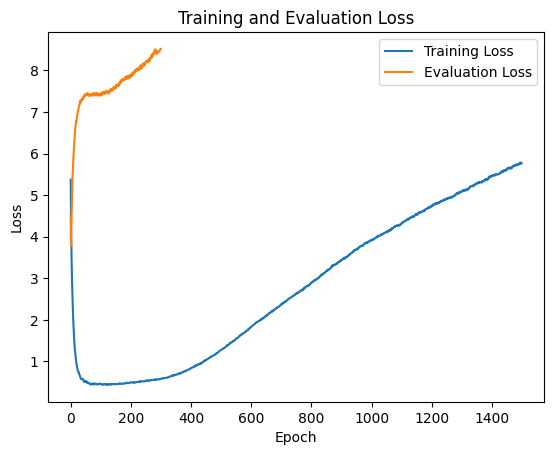

[5.372446208750755, 4.408008573983182, 3.8654470329006205, 3.43820219721083, 3.0788994657786515, 2.776198476256388, 2.5085109058576793, 2.2772815310250762, 2.0682286378614863, 1.891585909966633, 1.7339235257809904, 1.5984956555866776, 1.4688003106117813, 1.36047718115042, 1.2573771235789821, 1.2163683124416207, 1.1240049691797704, 1.0631060737666578, 0.9999874184139865, 0.9536026681136053, 0.909282773529088, 0.8782606733385969, 0.8184408648421555, 0.7917987101085857, 0.7773635974509401, 0.761407089598744, 0.7311803426004864, 0.7341639765724352, 0.7039198818708409, 0.6766366386802936, 0.6667393478615804, 0.6479832044574593, 0.6176852072594607, 0.6002752520591371, 0.5838595282483724, 0.5762542013838632, 0.5694861956902496, 0.5774377162568864, 0.578052692853075, 0.5768809969403879, 0.5753070315577964, 0.5769955792641382, 0.5541251030672657, 0.5313514652899781, 0.5092816777717196, 0.5236484086412805, 0.511769317065693, 0.5257803828217789, 0.5212664028171504, 0.5128699593978738, 0.523608175

In [495]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()
print(train_losses)
print(eval_losses)


In [496]:
def translate_dev(i):
    en_sent = " ".join([inv_en_dict[w] for w in dev_en[i]])  #原来的英文
    print(en_sent)
    cn_sent = " ".join([inv_cn_dict[w] for w in dev_cn[i]])  #原来的中文
    print("".join(cn_sent))

    mb_x = torch.from_numpy(np.array(dev_en[i]).reshape(1, -1)).long().to(device)
    mb_x_len = torch.from_numpy(np.array([len(dev_en[i])])).long().to(device)
    bos = torch.Tensor([[cn_dict["BOS"]]]).long().to(device)

    translation, attn = model.translate(mb_x, mb_x_len, bos)
    translation = [inv_cn_dict[i] for i in translation.data.cpu().numpy().reshape(-1)]
    trans = []
    for word in translation:
        if word != "EOS":
            trans.append(word)
        else:
            break
    print("".join(trans))           #翻译后的中文


for i in range(10, 49):
    translate_dev(i)
    print()

BOS well done ! EOS
BOS 做 得 好 ！ EOS
幾時出去！

BOS be serious . EOS
BOS 咪 玩 啦 。 EOS


/var/folders/sm/xc_yp0q16ps2v4zqf84_bbxc0000gn/T/ipykernel_77389/1649215179.py:25: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1647.)
  attn.data.masked_fill(mask, -1e6)


佢哋會減肥。

BOS be serious . EOS
BOS 認 真 啲 啦 。 EOS
男模特別地。

BOS it matters . EOS
BOS 重 要 。 EOS
升職業關係㗎。

BOS no problem . EOS
BOS 冇 問 題 。 EOS
冇到佢嚟。

BOS say please . EOS
BOS 講 唔 該 吖 。 EOS
你講得好多。

BOS start over . EOS
BOS 重 新 嚟 過 啦 。 EOS
啱晒啲衫。

BOS who talked ? EOS
BOS 邊 個 講 嘢 ？ EOS
邊個都唔係㗎？

BOS who yelled ? EOS
BOS 邊 個 嗌 呀 ？ EOS
嗰個高佬邊個嚟？

BOS please stay . EOS
BOS 請 留 步 。 EOS
唔該你，唔該。

BOS please stay . EOS
BOS 請 你 留 低 啦 。 EOS
唔該你。

BOS talk slower . EOS
BOS 講 慢 少 少 。 EOS
個嘢講嘅。

BOS abandon ship ! EOS
BOS 棄 船 呀 ！ EOS
買正一樣嘢喎！

BOS drive slowly . EOS
BOS 揸 慢 啲 。 EOS
喺九龍笪。

BOS speak slower . EOS
BOS 講 慢 少 少 。 EOS
男模特兒公仔。

BOS tom screamed . EOS
BOS T o m 尖 叫 。 EOS
將啲花出去。

BOS say something . EOS
BOS 講 啲 嘢 啦 。 EOS
佢一便講嘢啊。

BOS drive carefully . EOS
BOS 小 心 啲 揸 車 。 EOS
香港迪士嘅電話。

BOS UNK christmas ! EOS
BOS 聖 誕 節 快 樂 ！ EOS
海鮮好禁嘅！

BOS i get it . EOS
BOS 我 明 。 EOS
我有利。

BOS i get it . EOS
BOS 我 g e t 到 。 EOS
我仆喺家企喺門。

BOS i 'm here . EOS
BOS 我 喺 度 。 EOS
我有覺意好似落地。

BOS do n't cry . EOS
BOS 唔 好 喊 啦 。

In [498]:
# Open the file for appending
with open('output.txt', 'a') as f:
    # Loop through the numbers and translate them
    for i in range(10, 49):
        en_sent = " ".join([inv_en_dict[w] for w in dev_en[i]])  #原来的英文
        f.write(en_sent + '\n')

        cn_sent = " ".join([inv_cn_dict[w] for w in dev_cn[i]])  #原来的中文
        f.write(cn_sent + '\n')

        mb_x = torch.from_numpy(np.array(dev_en[i]).reshape(1, -1)).long().to(device)
        mb_x_len = torch.from_numpy(np.array([len(dev_en[i])])).long().to(device)
        bos = torch.Tensor([[cn_dict["BOS"]]]).long().to(device)

        translation, attn = model.translate(mb_x, mb_x_len, bos)
        translation = [inv_cn_dict[i] for i in translation.data.cpu().numpy().reshape(-1)]
        f.write('\n')
        trans = []
        for word in translation:
            if word != "EOS":
                trans.append(word)
            else:
                break
        translated = "".join(trans)           #翻译后的中文
        f.write(translated + '\n')
        f.write('\n')

        # Print the output to the console
        print(en_sent)
        print(cn_sent)
        print(translated)
        print()

# Close the file
f.close()


/var/folders/sm/xc_yp0q16ps2v4zqf84_bbxc0000gn/T/ipykernel_77389/1649215179.py:25: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1647.)
  attn.data.masked_fill(mask, -1e6)


BOS well done ! EOS
BOS 做 得 好 ！ EOS
喇！

BOS be serious . EOS
BOS 咪 玩 啦 。 EOS
佢好容易㗎。

BOS be serious . EOS
BOS 認 真 啲 啦 。 EOS
嗰隻生會好有電。

BOS it matters . EOS
BOS 重 要 。 EOS
佢做緊嘢。

BOS no problem . EOS
BOS 冇 問 題 。 EOS
你間超級佢。

BOS say please . EOS
BOS 講 唔 該 吖 。 EOS
你話佢哋搭生意。

BOS start over . EOS
BOS 重 新 嚟 過 啦 。 EOS
就去咗佢。

BOS who talked ? EOS
BOS 邊 個 講 嘢 ？ EOS
咪喐？

BOS who yelled ? EOS
BOS 邊 個 嗌 呀 ？ EOS
邊個噉行啊？

BOS please stay . EOS
BOS 請 留 步 。 EOS
唔該你。

BOS please stay . EOS
BOS 請 你 留 低 啦 。 EOS
唔該你。

BOS talk slower . EOS
BOS 講 慢 少 少 。 EOS
佢個女打波。

BOS abandon ship ! EOS
BOS 棄 船 呀 ！ EOS
隻船食水嘅！

BOS drive slowly . EOS
BOS 揸 慢 啲 。 EOS
呢粒事我喺度整緊。

BOS speak slower . EOS
BOS 講 慢 少 少 。 EOS
呢個煲嘅大戲。

BOS tom screamed . EOS
BOS T o m 尖 叫 。 EOS
藥煲衡得。

BOS say something . EOS
BOS 講 啲 嘢 啦 。 EOS
大家都係老細嘅。

BOS drive carefully . EOS
BOS 小 心 啲 揸 車 。 EOS
機嘅功課室係心。

BOS UNK christmas ! EOS
BOS 聖 誕 節 快 樂 ！ EOS
崖門！

BOS i get it . EOS
BOS 我 明 。 EOS
我諗到都係條線。

BOS i get it . EOS
BOS 我 g e t 到 。 EOS
我好鍾意。

BOS i 'm